# Autoenconder:

## Introdução:

Autoenconders são métodos não supervisionados de trabalharmos com redes neurais sem muito parâmetros.

A ideia principal do método é promover uma abordagem simples para extrair os *features* do modelo removendo a redundância. **É imporante antes de qualquer evolução teórica entender o que seria essa redundância. O texto base que estou usando não fornece tantas informações para compreender. Procurar outra fonte.**


Vamos de início importar o banco de dados utilizado nesse problema.

Até aqui usaremos o banco de dados MNIST, mas isso não importa muito no momento. A única coisa que queremos nessa etapa do projeto é o conjunto de imagens fornecidas; Podemos usar qualquer banco de dados.

O método de compressão de imagens JPEG é um método de se trabalhar com essas redundâncias. O processo do JPEG é rodeado pela transformação chamada *discrete cosine transformation* que implica em imagens que a maioria das posições são ocupadas por vários zeros e depois ocupadas por números inteiros. **Acredito que nesse momento também seria interessante de entender quais os princípios da transfomração JPEG**. Nesse processo, infelizmente ainda temos a perda de informação uma vez que na recoonstrução dessa informação não conseguimos constrí-lo de forma completa.

Analogamente, o método de *Autoencoding* visa fazer a compressão de dados e depois reconstruir através dos parâmetros aprendidos e por isso, Gallinari & LeCun propuseram a ideia de trabalhar com autoencoders como eliminadores de rúido porém hoje em dia também são amplamente utilizados como geradores de informação.

In [ ]:
#Bibliotecas iniciais
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from random import randint

## MNIST:

Para trabalharmos com redes neurais devemos principalmente trabalhar com segmentações nos bancos de dados para facilitar a etapa de treinamento e validação.

Os dados que trabalharemos aqui é segmentado com 60000 imagens no banco de treinamento e outras 10000 para validação.

In [44]:
#Importação do banco de dados em conjunto de treinamento e teste.
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalização dos dados
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Adicionar uma dimensão extra para corresponder à entrada (batch, height, width, channels)
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

Visualização das imagens do banco de dados:

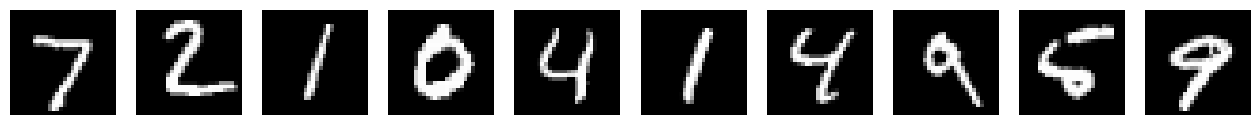

In [45]:
fig, axs = plt.subplots(1,10,figsize=(16,2), dpi=100)
for ax in axs.ravel():
    ax.set_axis_off()

for i,j in enumerate(x_test[:10]):
  axs[i].imshow(j, cmap='gray')
plt.show()

## Estruturação:

Nesse ponto vamos mudar um pouco a abordagem que usamos normalmente para trabalhar com imagens. Até o momento, só estudamos métodos convolucionais para analisar e reconhecer imagens, nesse modelo de Autoencoding vamos achatar a imagem e trabalhar cada pixel como um neurônio individual.

Portanto, nesse limiar nosso input_layer será por sua vez cada imagem do conjunto de treino, em seguida, na primeira Flatten Layer, achatamos a imagem em um vetor de tamanho 748 (28$\times$28).

Esses vetores passarão por uma camada de 100 neurônios, e em seguida passamos pela primeira Hidden Layer com 20 neurônios. Finalmente, o output do encoder será 20 features (proporcional a quantidade de neurônio na última Hidden Layer).

In [57]:
# Definição do Encoder
input_layer = layers.Input(shape=x_train.shape[1:])
flattened = layers.Flatten()(input_layer)
hidden = layers.Dense(hidden_size, activation='relu')(flattened)
latent = layers.Dense(latent_size, activation='relu')(hidden)
encoder = Model(inputs=input_layer, outputs=latent, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,060 (402.58 KB)

 Trainable params: 103,060 (402.58 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Calculando o tamanho da camada densa de saída no decoder
output_shape = x_train.shape[1:]
output_units = output_shape[0] * output_shape[1] * output_shape[2]

In [59]:
# Definição do Decoder
input_layer_decoder = layers.Input(shape=(latent_size,))
upsampled = layers.Dense(hidden_size, activation='relu')(input_layer_decoder)
upsampled = layers.Dense(output_units, activation='relu')(upsampled)
constructed = layers.Reshape(output_shape)(upsampled)
decoder = Model(inputs=input_layer_decoder, outputs=constructed, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,824 (405.56 KB)

 Trainable params: 103,824 (405.56 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Definição do Autoencoder
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 20)             │         2,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       103,824 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,884 (808.14 KB)

 Trainable params: 206,884 (808.14 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=64, validation_data = (x_test, x_test))

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0176 - val_loss: 0.0172
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0173 - val_loss: 0.0170
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0170 - val_loss: 0.0161
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0163 - val_loss: 0.0159
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0161 - val_loss: 0.0158
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 12/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

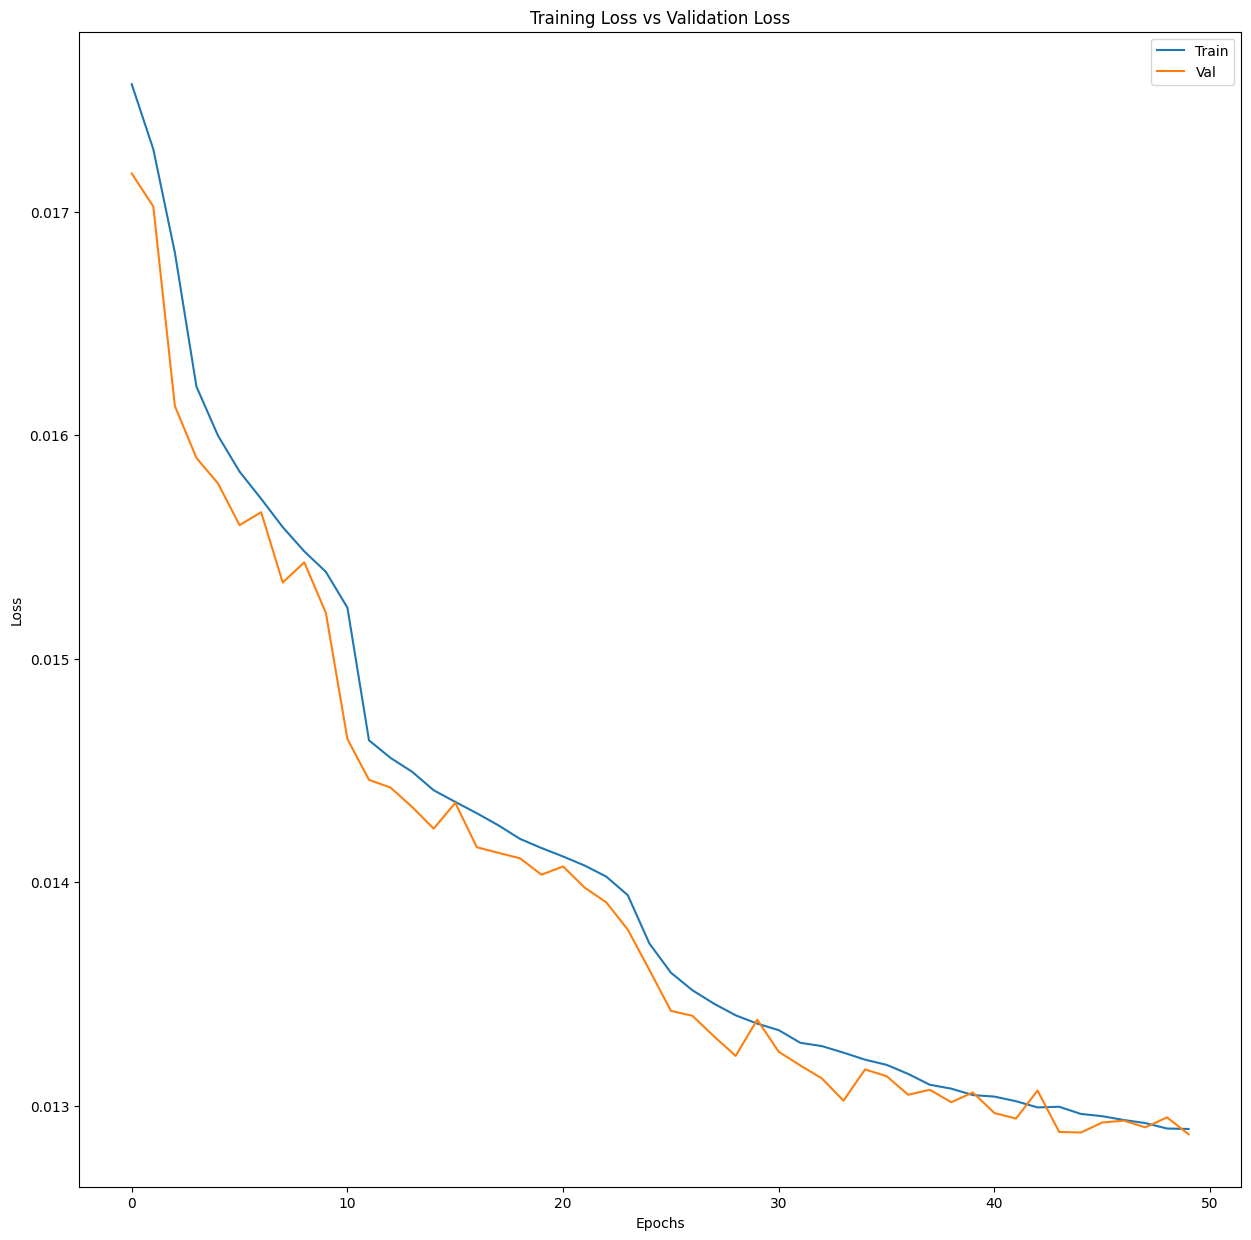

In [63]:
fig, axs = plt.subplots(figsize=(15,15))
axs.plot(history.history['loss'])
axs.plot(history.history['val_loss'])
axs.title.set_text('Training Loss vs Validation Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend(['Train','Val'])

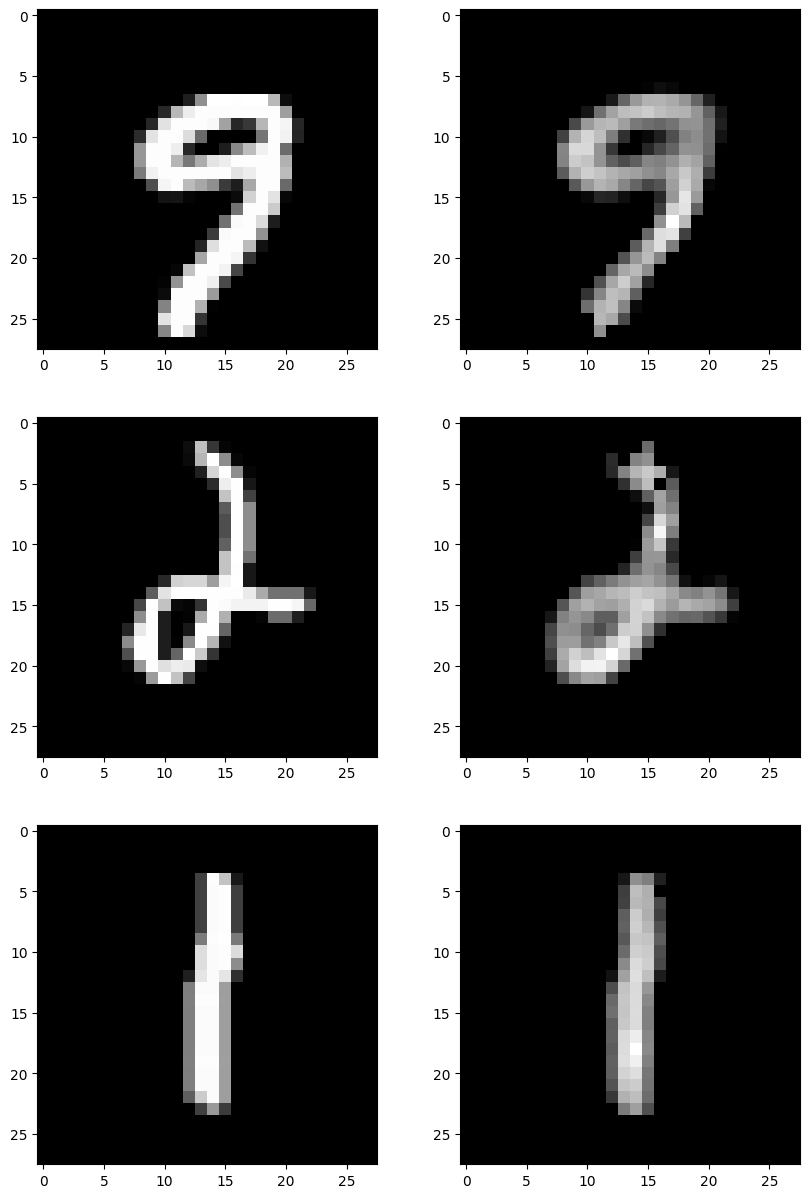

In [70]:
fig, axs = plt.subplots(3,2,figsize=(10,15))
for i in range(3):
  sample1 = x_train[randint(0,x_train.shape[0])]
  axs[i][0].imshow(sample1, cmap = 'gray')
  axs[i][0].set_axis_off
  axs[i][1].imshow(autoencoder(np.expand_dims(sample1,0))[0], cmap = 'gray')
  axs[i][1].set_axis_off